[Functions](#func)

[Tasks](#task)
- [Анализ чувствительности. Классический запуск](#first)
- [Анализ чувствительности. Ускорение с Numba](#second)
- [Анализ чувствительности. Распараллеливание](#third)
  * [Multiprocessing](#mproc)
  * [SALib parallel](#spar)

In [10]:
import time
import numba
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from matplotlib.pyplot import figure
from math import sin, cos, tan, pi
from SALib.sample import saltelli
from SALib.analyze import sobol

# Проведите анализ чувствительности, проверьте сходимость, измерьте тайминги

<a name = "func"/>

In [11]:
problem = {
    'num_vars' : 3,
    'names' : ['x1', 'x2', 'x3'],
    'bounds' : [[-10, 10],
                [-10, 10],
                [-10, 10]]}

In [12]:
N = 2 ** 15

def model_for_eval(x):
    return cos(x[1]) + sin(x[1]) - sin(x[0]) ** 4 * cos(x[2]) ** 4

@numba.njit
def model_for_eval_numba(x):
    return cos(x[1]) + sin(x[1]) - sin(x[0]) ** 4 * cos(x[2]) ** 4


def run_SA(problem, model_func, N, parallel_on = False):
    
    start = time.time()
    param_values = saltelli.sample(problem, N)
    print("Генерирование семпла занимает %s секунд" %(time.time() - start))
    Y = np.zeros([param_values.shape[0]])

    start = time.time()
    for i, X in enumerate(param_values):
        Y[i] = model_func(X)
    print("Оценка функции занимает %s секунд" %(time.time() - start))

    start = time.time()
    Si = sobol.analyze(problem, Y, parallel = parallel_on)
    print("Sobol анализ занимает %s секунд" %(time.time() - start))
    print("\n")
    print("ST:", Si['ST'])
    print("S1: ", Si['S1'])
    
    return Si#, sampling_time, eval_time, sa_time


from help_func import sample_func_
def sample_func_multiproc(problem, n_samples):
    
    num_cpu = 4
    print('CPU ядер: ', num_cpu)
    n_samples_on_cpu = n_samples // num_cpu
    print("Семплов на ядро: ", n_samples_on_cpu)
    res = []
    
    with mp.Pool(num_cpu) as pool:
        res = pool.map(sample_func_, [(problem, n_samples_on_cpu, i + 1) for i in range(num_cpu)])
    return res


plt.rcParams["figure.figsize"] = (15,6)

<a name = "task"/>

<a name = "first"/>

# 1) Классический запуск

Генерирование семпла занимает 1.5040476322174072 секунд
Оценка функции занимает 0.4359445571899414 секунд
Sobol анализ занимает 1.568894863128662 секунд


ST: [0.03724876 0.94649538 0.03352609]
S1:  [0.01997535 0.94649488 0.01661716]


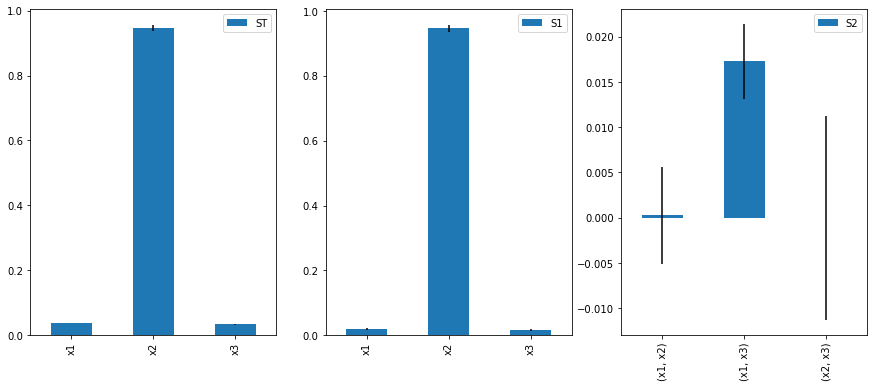

In [13]:
Si = run_SA(problem, model_for_eval, N)
Si.plot();

<a name = "second"/>

# 2) Ускорение, использую numba

Генерирование семпла занимает 1.494225263595581 секунд
Оценка функции занимает 0.14047574996948242 секунд
Sobol анализ занимает 1.626983642578125 секунд


ST: [0.03724876 0.94649538 0.03352609]
S1:  [0.01997535 0.94649488 0.01661716]


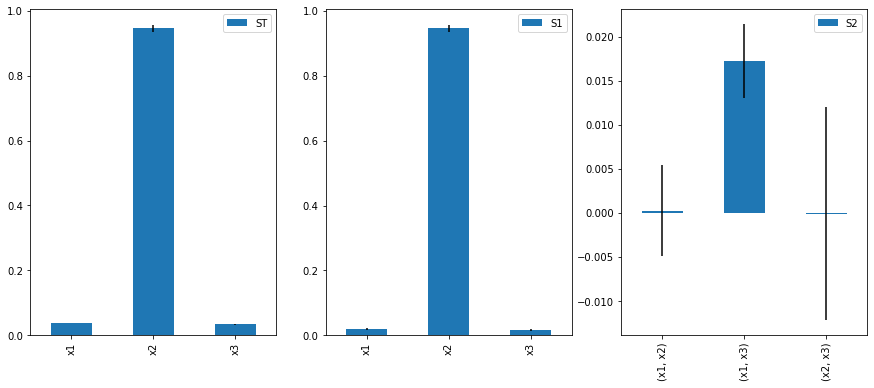

In [16]:
Si = run_SA(problem, model_for_eval_numba, N)
Si.plot();

# Как видим, оценку ускорили больше чем в 3 раза

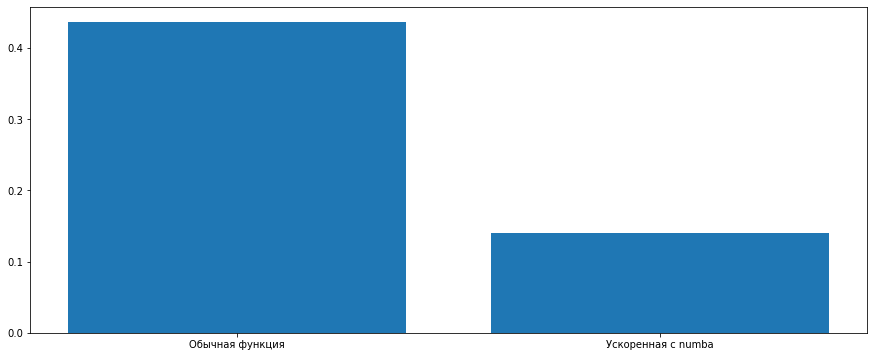

In [17]:
plt.bar(['Обычная функция', 'Ускоренная с numba'], [0.436, 0.140]);

<a name = "third"/>


# 3) Добавляем параллелизм

<a name = "mproc"/>

# Multiprocessing

In [19]:
start = time.time()
res = sample_func_multiproc(problem, N)
print(time.time() - start)

CPU ядер:  4
Семплов на ядро:  8192
1.6872265338897705


In [8]:
np.all(res[0] == res[1]), np.all(res[1] == res[2])

(True, True)

#### Да, результат по генерации семпла не очень хорош в паралельном варианте, т.е нет улучшения (1.69 против 1.5 в классике). Более тего, проверка на семплы показывает, что сгенерировались одинаковые массивы, что никак не улучшает анализ. Отсюда в данном случае параллелизм не помогает

<a name = "spar"/>

# Ускорим с применением флага на параллелизм в библиотеке SALib

In [20]:
Si = run_SA(problem, model_for_eval_numba, N, parallel_on = True)

Генерирование семпла занимает 1.534055471420288 секунд
Оценка функции занимает 0.15628480911254883 секунд
Sobol анализ занимает 2.878899574279785 секунд


ST: [0.03724876 0.94649538 0.03352609]
S1:  [0.01997535 0.94649488 0.01661716]


#### Как видим, Sobol анализ не ускорился с применением параллелизма внутри библиотеки. Стало 2.88 против 1.63 секунд до применения parallel=True, при использовании numba